Potrzebne importy

In [1]:
import numpy as np
import skimage as ski
import math as m
import pydicom._storage_sopclass_uids
import datetime, time
import ipywidgets as widgets
import warnings
from skimage import io
from skimage.filters.edges import convolve
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity
from matplotlib import pyplot as plt
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
from pydicom import dcmread
from IPython.display import clear_output
from ipywidgets import interact, Layout

warnings.simplefilter(action='ignore', category=FutureWarning)

Klasa zawierająca wszystkie parametry:

In [2]:
class Parameters:
    def __init__(self, filename, steps, detectors, alfa, l, reduce_radius, use_filtr, animated):
        try:
            self.img = io.imread(filename, as_gray=True)
        except (ValueError, FileNotFoundError):
            self.img = None
            print("Nie ma takiego pliku")
        self.steps = steps
        self.detectors = detectors
        self.alfa = alfa
        self.l = l
        self.reduce_radius = reduce_radius
        self.use_filtr = use_filtr
        self.animated = animated

Transformata Radona- Sinogram:

In [3]:
def sinogram(img, imgShape, steps, l, detectors, alfa, reduce_radius, use_filtr, animated, inverse=False, result_animation=[]): 
    deltaAlfa = m.radians(alfa / steps)
    width, height = imgShape
    center_x=(int)(width / 2)
    center_y= (int)(height / 2)
    if width==height:
        radius_x = radius_y =  center_x - reduce_radius
    else:
        radius_x = center_x - reduce_radius
        radius_y = center_y - reduce_radius
    angle = 0
    
    if inverse==False:
        sinog= np.zeros((steps,detectors))
    else:
        sinog = np.zeros((width,height))
        result_animation = []
        
    
    #przesunięcie emitera i detektorów (model stożkowy)
    for i in range(steps):
        #przesunięcie emitera
        x = center_x + int(radius_x * np.cos(angle))
        y = center_y + int(radius_y * np.sin(angle))
        #wyliczenie "polożenia kątowego" pierwszego detektora
        tmpDetectorAngle = m.radians(180 - l/2) + angle
        detectorStep = m.radians(l / (detectors - 1))
        for j in range(detectors):
            #przesunięcie detektorów
            xDet = center_x + int(radius_x * np.cos(tmpDetectorAngle))
            yDet = center_y + int(radius_y * np.sin(tmpDetectorAngle))
            tmpDetectorAngle += detectorStep
            #wykorzystanie algorytmu Brenshema
            if(inverse==False):
                sinog[i][j]=BresenhamAlgorithm(img, x, y, xDet, yDet, inverse)
            else:
                sinog = BresenhamAlgorithm(sinog, x, y, xDet, yDet, inverse, img[i][j])
                
        
        if(animated==True):
            if (inverse==False):
                pass
            else:
                result_animation.append(sinog.copy())
        #przesunięcie kątowe dla następnego kroku
        angle += deltaAlfa
    if(inverse==False):
        if use_filtr==True:
            #filtracja sinogramu
            sinog=filtredSinogram(sinog)
    else:
        #normalizacja oraz poprawa wyniku po odwrotnej transformacie Radona
        sinog= normalize(sinog**2)**0.5
        result_animation.append(sinog.copy())

    return sinog, result_animation

Funkcja normalizacji:

In [4]:
def normalize(sinog):
    maksimum = np.max(sinog)
    minimum = np.min(sinog)
    if (maksimum-minimum)!=0:
        sinog = (sinog-minimum)/(maksimum-minimum)
    return sinog

Funkcja do filtracji sinogramu:

In [5]:
def filtredSinogram(sinog, kernelSize=21):
    mask=[]
    for i in range((int)(kernelSize/2)+1):
        if(i==0):
            mask.append(1.0) 
        elif(i%2==0):
            mask.append(0.0)
        else:
            mask.append((-4)/np.pi**2/i**2)
    mask=mask[::-1]+mask[1:]
    for i in range(len(sinog)):
        sinog[i,:]=np.convolve(sinog[i,:],mask, mode='same')
    return sinog

Algorytm Bresenhama- liniowe przejście po kolejnych pikselach obrazu dyskretnego ~ https://en.wikipedia.org/wiki/Bresenham's_line_algorithm

In [6]:
def BresenhamAlgorithm(img, x, y, x2, y2, inverse, brightness=0):
    suma = 0 #suma kolorów na jednym pikselu
    
    dx=abs(x-x2) #różnica w poziomie (emiter-detektor)
    dy=abs(y-y2) #różnica w pionie (emiter-detektor)
    
    #zmiana pozycji (pion/poziom)
    sx=1 if x < x2 else -1
    sy=1 if y < y2 else -1
    
    #wyznaczenie średniej wartości pixela (patrz algorytm Brenshema)
    if dx > dy:
        return plotLineLow(img, suma,dx,dy,x,y,sx,sy,x2, inverse, brightness)
    else:
        return plotLineHigh(img, suma,dx,dy,x,y,sx,sy,y2, inverse, brightness)

Przejście po ujemnym "stromym zboczu" ~ https://en.wikipedia.org/wiki/Bresenham's_line_algorithm

In [7]:
def plotLineLow(img, suma,dx,dy,x,y,sx,sy,x2, inverse, brightness):
    #usprawnienie obliczeń
    a = (dy - dx) * 2 
    b = dy * 2
    D = b - dx
    #licznik iteracji
    it=0
    while x != x2:
        
        
        if(inverse==False):
            #pobranie koloru
            suma += img[x][y]
            it+=1
        else:
            #wzmocnienie obrazu przy użyciu sinogramu
            img[x][y] += brightness
        
        if D >= 0:
            x += sx
            y += sy
            D += a
        else:
            D += b
            x += sx
        
    if(inverse==False):
        return suma/it
    else:
        return img

Przejście po dodatnim "stromym zboczu" ~ https://en.wikipedia.org/wiki/Bresenham's_line_algorithm

In [8]:
def plotLineHigh(img, suma,dx,dy,x,y,sx,sy,y2, inverse, brightness):
    #usprawnienie obliczeń
    a = (dx - dy) * 2
    b = dx * 2
    D = b - dy
    #licznik iteracji
    it=0
    
    while y != y2:
        if(inverse==False):
            #pobranie koloru 
            suma += img[x][y]
            it+=1
        else:
            #wzmocnienie obrazu przy użyciu sinogramu
            img[x][y] += brightness

        if D >= 0:
            x += sx
            y += sy
            D += a
        else:
            D += b
            y += sy  
        
    if(inverse==False):
        return suma/it
    else:
        return img

Zapisywanie do formatu DICOM:

In [9]:
def save_as_dicom(file_name, img, patient_data):
    img_converted = img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(file_name, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    ds.ContentDate = str(datetime.date.today()).replace('-','')
    ds.ContentTime = str(time.time())

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)

Wczytywanie obrazu DICOM

In [10]:
def read_dicom(file_name):
    ds = dcmread(file_name, force=True)
    print(ds)
    io.imshow(file_name)

Obliczenie błędu średniokwadratowego:

In [11]:
def RootMeanSquaredError(img, img2):
    err = np.sum((normalize(img) - img2) ** 2)
    err /= (img.shape[0] * img.shape[1])
    return m.sqrt(err)

Funkcja uruchamiająca program:

In [15]:
def runProgram(Init):
    result_animation = []
    sinog = []
    fillingMatrix = np.zeros((Init.steps, Init.detectors)) #wypełnienie sinog'a
    def draw_step_of_sinogram(step_number):
        plt.figure()
        io.imshow(rgb2gray(np.row_stack((sinog[:(step_number-1)], fillingMatrix[(step_number-1):]))), cmap=plt.cm.gray)
    def draw_step_of_result(step_number):
        plt.figure()
        io.imshow(rgb2gray(result_animation[step_number-1]), cmap=plt.cm.gray)
    io.imshow(Init.img)
    plt.show()
    sinog, _ = sinogram(Init.img, Init.img.shape, Init.steps, Init.l, Init.detectors, Init.alfa, Init.reduce_radius, Init.use_filtr, Init.animated, False)
    
    sinogInv, result_animation = sinogram(sinog, Init.img.shape, Init.steps, Init.l, Init.detectors, Init.alfa, Init.reduce_radius, Init.use_filtr, Init.animated, True, result_animation)
    
    if(Init.animated == True):
        interact(draw_step_of_sinogram, step_number=widgets.IntSlider(min=1, max=Init.steps, step=1, value=1))
        interact(draw_step_of_result, step_number=widgets.IntSlider(min=1, max=len(result_animation), step=1, value=1))
    else:
        plt.figure()
        io.imshow(rgb2gray(sinog), cmap=plt.cm.gray)
        plt.figure()
        io.imshow(rgb2gray(result_animation[-1]), cmap=plt.cm.gray)
    print("Root mean squared error: " + str(RootMeanSquaredError(Init.img, sinogInv)))
    return sinogInv

Text(value='Shepp_logan.jpg', description='File name:', style=DescriptionStyle(description_width='100px'))

BoundedIntText(value=360, description='Alfa:', max=360, min=1, style=DescriptionStyle(description_width='100px…

BoundedIntText(value=180, description='l:', max=360, min=1, style=DescriptionStyle(description_width='100px'))

BoundedIntText(value=3, description='Reduce Radius:', max=10, min=1, style=DescriptionStyle(description_width=…

BoundedIntText(value=100, description='Steps:', max=1000, min=1, style=DescriptionStyle(description_width='100…

BoundedIntText(value=180, description='Detectors:', max=1000, min=21, style=DescriptionStyle(description_width…

Checkbox(value=True, description='Use filter:', style=DescriptionStyle(description_width='100px'))

Checkbox(value=True, description='Animated:', style=DescriptionStyle(description_width='100px'))

Button(description='Uruchom Program', layout=Layout(width='200px'), style=ButtonStyle())

Text(value='test.dcm', description='Dicom load file:', style=DescriptionStyle(description_width='100px'))

Button(description='Wczytaj plik DICOM', layout=Layout(width='200px'), style=ButtonStyle())

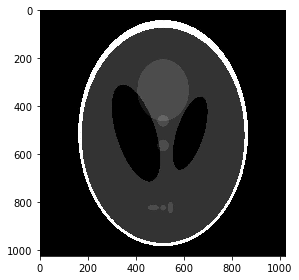

interactive(children=(IntSlider(value=1, description='step_number', min=1), Output()), _dom_classes=('widget-i…

interactive(children=(IntSlider(value=1, description='step_number', max=101, min=1), Output()), _dom_classes=(…

Root mean squared error: 0.20797310866513333


Text(value='test.dcm', description='Dicom save file:', style=DescriptionStyle(description_width='100px'))

Text(value='name', description='Patient name:', style=DescriptionStyle(description_width='100px'))

Text(value='id', description='Patient id:', style=DescriptionStyle(description_width='100px'))

Text(value='comment', description='Image comments:', style=DescriptionStyle(description_width='150px'))

Button(description='Zapisz plik DICOM', layout=Layout(width='200px'), style=ButtonStyle())

In [13]:
buttonLayout=Layout(width='200px')
editStyle = {'description_width': '100px'}

#deklaracja elementów interfejsu graficznego
editFilename = widgets.Text(value='kwadraty2.jpg', description='File name:', style=editStyle)
editAlfa = widgets.BoundedIntText(value=360, min=1, max=360, step=1, description="Alfa:", style=editStyle)
editL = widgets.BoundedIntText(value=180, min=1, max=360, step=1, description="l:", style=editStyle)
editReduceRadius = widgets.BoundedIntText(value=3, min=1, max=10, step=1, description="Reduce Radius:", style=editStyle)
editSteps = widgets.BoundedIntText(value=50, min=1, max=1000, step=1, description="Steps:", style=editStyle)
editDetectors = widgets.BoundedIntText(value=180, min=21, max=1000, step=1, description="Detectors:", style=editStyle)
editUseFiltr = widgets.Checkbox(value=True, description='Use filter:', style=editStyle)
editAnimated = widgets.Checkbox(value=True, description='Animated:', style=editStyle)

buttonStartProgram = widgets.Button(description='Uruchom Program', layout=buttonLayout)
editFilenameSaveDicom = widgets.Text(value='test.dcm', description='Dicom save file:', style=editStyle)
buttonSaveDicom = widgets.Button(description='Zapisz plik DICOM', layout=buttonLayout)

editPatientName = widgets.Text(value='name', description='Patient name:', style=editStyle)
editPatientID = widgets.Text(value='id', description='Patient id:', style=editStyle)
editImageComments = widgets.Text(value='comment', description='Image comments:', style={'description_width': '150px'})

editFilenameLoadDicom = widgets.Text(value='test.dcm', description='Dicom load file:', style=editStyle)
buttonLoadDicom = widgets.Button(description='Wczytaj plik DICOM', layout=buttonLayout)



def resetGUI(saveAvilable):
    clear_output(wait=True)
    display(editFilename)
    display(editAlfa)
    display(editL)
    display(editReduceRadius)
    display(editSteps)
    display(editDetectors)
    display(editUseFiltr)
    display(editAnimated)
    display(buttonStartProgram)
    display(editFilenameLoadDicom)
    display(buttonLoadDicom)

def on_start_button_clicked(buttonStartProgram):
    resetGUI(True)
    Init = Parameters(editFilename.value, editSteps.value, editDetectors.value, editAlfa.value, editL.value, editReduceRadius.value,
                        editUseFiltr.value, editAnimated.value)
    if(len(Init.img) > 0):
        sinogInv = runProgram(Init)
        def on_save_dicom_button_clicked(buttonSaveDicom):
            patient_data={'PatientName': editPatientName.value, 'PatientID': editPatientID.value, 'ImageComments': editImageComments.value}
            save_as_dicom(editFilenameSaveDicom.value, sinogInv, patient_data)
            print("Zapisano plik DICOM!")
        display(editFilenameSaveDicom)
        display(editPatientName)
        display(editPatientID)
        display(editImageComments)
        display(buttonSaveDicom)
        buttonSaveDicom.on_click(on_save_dicom_button_clicked)

def on_load_dicom_button_clicked(buttonLoadDicom):
    resetGUI(False)
    if(len(editFilenameLoadDicom.value) > 0):
        try:
            dicomLoaded = read_dicom(editFilenameLoadDicom.value)
        except FileNotFoundError:
            print("Nie ma takiego pliku!")
    else:
        print("Podaj nazwę pliku!")

buttonStartProgram.on_click(on_start_button_clicked)
buttonLoadDicom.on_click(on_load_dicom_button_clicked)
resetGUI(False)